## Importing Necessary Libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

### Getting the Data

In [1]:
!curl -O http://www.manythings.org/anki/hin-eng.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  131k  100  131k    0     0   569k      0 --:--:-- --:--:-- --:--:--  570k


### Unzipping the Data

In [2]:
!unzip hin-eng.zip

Archive:  hin-eng.zip
  inflating: hin.txt                 
  inflating: _about.txt              


## Preprocessing

In [1]:
file_path = "hin.txt"

# Open the file and count the lines
with open(file_path, "r", encoding="utf-8") as file:
    num_samples = sum(1 for line in file)

print("Number of samples:", num_samples)

Number of samples: 2979


In [2]:
batch_size = 64  # Batch size for training.
epochs = 770  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples =1500  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "hin.txt"

### Data Preparation

In [5]:
# Vectorize the data.
input_texts = []
target_texts = []

input_characters = set()
target_characters = set()

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 1500
Number of unique input tokens: 69
Number of unique output tokens: 84
Max sequence length for inputs: 29
Max sequence length for outputs: 60


### Model Building

In [7]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

### Model Training

In [8]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/770


2023-10-30 09:13:30.892130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-30 09:13:30.970066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-30 09:13:30.971218: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x20368940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-30 09:13:30.971234: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-30 09:13:30.974016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-30 09:13:31.026071: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

19/19 [==============================] - 2s 30ms/step - loss: 2.1621 - accuracy: 0.6363 - val_loss: 2.2011 - val_accuracy: 0.5773
Epoch 2/770
19/19 [==============================] - 0s 8ms/step - loss: 1.6466 - accuracy: 0.6721 - val_loss: 2.4079 - val_accuracy: 0.5773
Epoch 3/770
19/19 [==============================] - 0s 8ms/step - loss: 1.6205 - accuracy: 0.6742 - val_loss: 2.0621 - val_accuracy: 0.5825
Epoch 4/770
19/19 [==============================] - 0s 8ms/step - loss: 1.5192 - accuracy: 0.6757 - val_loss: 1.9680 - val_accuracy: 0.5830
Epoch 5/770
19/19 [==============================] - 0s 8ms/step - loss: 1.4654 - accuracy: 0.6778 - val_loss: 1.8554 - val_accuracy: 0.5830
Epoch 6/770
19/19 [==============================] - 0s 8ms/step - loss: 1.4112 - accuracy: 0.6778 - val_loss: 1.7949 - val_accuracy: 0.5830
Epoch 7/770
19/19 [==============================] - 0s 8ms/step - loss: 1.4013 - accuracy: 0.6780 - val_loss: 1.8712 - val_accuracy: 0.5830
Epoch 8/770
19/19 [=====

INFO:tensorflow:Assets written to: s2s/assets


### Viz Accuracy and Loss Curves

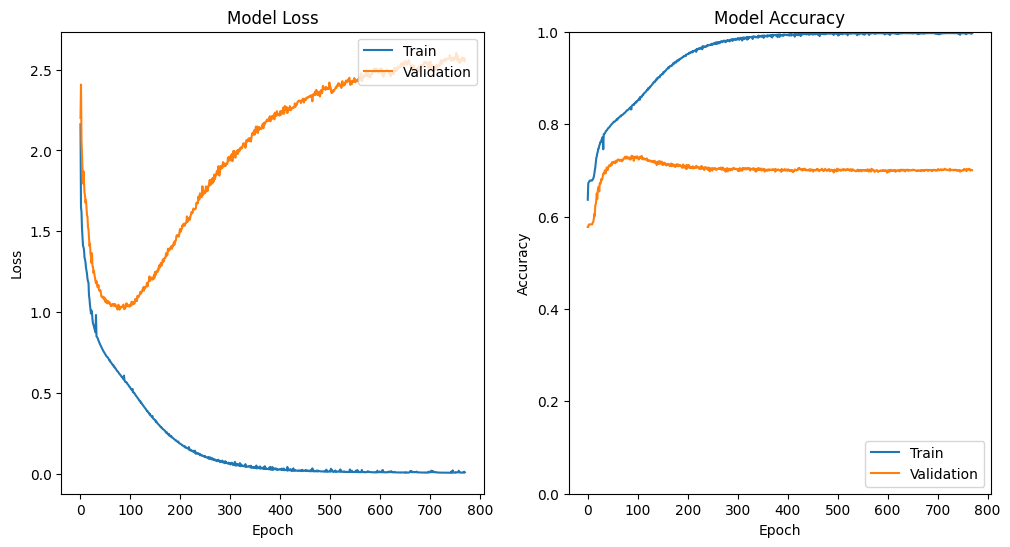

In [9]:
import matplotlib.pyplot as plt

# Assuming you have stored the training history in a variable called 'history'.
# The 'history' variable typically contains 'loss' and 'accuracy' values for each epoch.

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

### Run Inference

In [10]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

## Testing 

In [13]:
import random

for _ in range(150):
    # Generate a random sequence index within the valid range
    seq_index = random.randint(0, len(encoder_input_data) - 1)

    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]    
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 11ms/step
-
Input sentence: We would die without air.
Decoded sentence: हम हवा के बिना मर जाएँगे।

1/1 [==============================] - 0s 11ms/step
-
Input sentence: He treats me like his slave.
Decoded sentence: उसने हमें चुप्रे होन क्या?

1/1 [==============================] - 0s 11ms/step
-
Input sentence: That was my mistake.
Decoded sentence: वह मेरी ग़लती थी।

1/1 [==============================] - 0s 13ms/step
-
Input sentence: Would you mind if I smoke?
Decoded sentence: मेरे सिगरेट पीने पर आपको आपत्ति तो नहीं होगी?

1/1 [==============================] - 0s 11ms/step
-
Input sentence: We're going home.
Decoded sentence: हम घर जा रहें हैं।

1/1 [==============================] - 0s 11ms/step
-
Input sentence: It's no use arguing with him.
Decoded sentence: इससे मेरे कोई लेना-देना नहीं है।

1/1 [==============================] - 0s 11ms/step
-
Input sentence: He is smelling the soup.
Decoded sentence: वह सूप को सूँघ रहा है।

1/1 [====